Notebook to accompany article by Arseniev-Koehler and Foster, "Teaching an algorithm what it means to be fat: machine-learning as a model for cultural learning." All code last checked on Python 3 in Windows 1/3/2019. Please cite our paper or [GitHub repo](https://github.com/arsena-k/Word2Vec-bias-extraction) if reused. 

# More Manly or Womanly? Measuring Cultural Dimensions in Word2Vec Models with the Bolukbasi and Larsen Methods

This research explores how language around body weight in the news is loaded with meanings of gender, morality, healthiness, and socio-economic status (SES). For example, is "obese" more masculine or feminine? What about "slender"? 

In this notebook, extract cultural dimensions corresponding to gender, morality, health, and SES, respectively. We use two methods, first the Bolukbasi method and then the Larsen method. The Bolukbasi method is inspired by [Bolukbasi et. al. 2016](https://arxiv.org/abs/1607.06520) and the Larsen method is inspired by [Larsen et. al. 2016](https://arxiv.org/abs/1512.09300?context=cs). 

For a third method to classify words accoridng to these cultural dimensnons, that involves a quite different framework, see our notebook for [Part D](https://github.com/arsena-k/Word2Vec-bias-extraction). 

We start by loading up a trained Word2Vec model on news. We include two possible pre-trained models from our paper. See [Part A](https://github.com/arsena-k/Word2Vec-bias-extraction) of this project for a tutorial on training and understanding a Word2Vec model. Or, for a review of Word2Vec see this [blog post](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/). 

**Table of Contents**

* Part 1: [Load up libraries and a Word2Vec Model](#LoadUp)
* Part 2: [Explanation of Classification Method](#Motivation)
* Part 3: [Functions to Extract a Dimension](#HelperFunctions)
* Part 4: [Robustness Checks](#Robustness)
* Part 5: [Visualize how this Dimension Classifies words according to Gender, Morality, Health, and SES](#Results)


*This is a long notebook. For an abbreviated version, just do Parts 1-2 to get the ideas and see simple examples in Python. Or, to jump to visualizing the results, do Parts 1-2 and 4-5, thus skipping the robustness checks*

<a id='LoadUp'></a>
# Part 1. Load up libraries and a Word2Vec Model

In [1]:
#load up libraries (you may need to install some of these, with conda install or pip install, if not already installed)
import numpy as np
from csv import writer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold 
from gensim.models import Word2Vec, KeyedVectors
from sklearn import preprocessing
from statistics import mode, mean, stdev
import matplotlib.pyplot as plt
from scipy import spatial
from seaborn import stripplot
from pylab import rcParams
from pylab import xlim
from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline
#np.set_printoptions(threshold=np.inf) #uncomment this to print full output, such as to see all elements in a high dimensional vector

**Load up a pretrained Word2Vec Model**

*Option 1:* Use the Word2Vec model that we used in our paper, and trained on New York Times articles on body weight and health. 
Please see our paper for training details. 
* Download our model, called 'modelA_ALLYEARS_500dim_10CW' from our [OSF](https://osf.io/jvarx/files/), and put it in your working directory. Your working directory is the folder where this Jupyter notebook is currently saved. As written, the code assumes that your downloads folder is your working directory. 

In [2]:
#    An example for a PC computer if your model is in your downloads folder, and you're using a model named "modelA_ALLYEARS_500dim_10CW" 
#currentmodel=  Word2Vec.load("C:/Users/Alina Arseniev/Downloads/modelA_ALLYEARS_500dim_10CW")

#   An example for a Mac if your model is in your downloads folder, and you're using a model named "modelA_ALLYEARS_500dim_10CW" 
#currentmodel=  Word2Vec.load("~/Downloads/modelA_ALLYEARS_500dim_10CW")

#   An example based on my set-up of folders:
currentmodel=  Word2Vec.load("Word2VecModels/modelA_ALLYEARS_500dim_10CW") #load up a trained Word2Vec model. You'll need to tailor this path to your computer

In [3]:
currentmodel.wv.most_similar('woman', topn=10)

[('young_woman', 0.7615835070610046),
 ('girl', 0.6503051519393921),
 ('young_girl', 0.6443690061569214),
 ('housewife', 0.6167056560516357),
 ('man', 0.6113157868385315),
 ('nun', 0.6023279428482056),
 ('little_girl', 0.5948294401168823),
 ('pregnant_woman', 0.5898661613464355),
 ('prostitute', 0.5790244936943054),
 ('blonde', 0.578740656375885)]

In [4]:
currentmodel.wv.most_similar('america', topn=10)

[('nation', 0.5602331757545471),
 ('country', 0.4352755546569824),
 ('american', 0.42826521396636963),
 ('britain', 0.42289999127388),
 ('japan', 0.42218026518821716),
 ('world', 0.4114736318588257),
 ('europe', 0.4051887094974518),
 ('africa', 0.40183204412460327),
 ('continent', 0.3992503583431244),
 ('capitalism', 0.39811018109321594)]

In [5]:
currentmodel.wv.most_similar('paris', topn=10)

[('milan', 0.730395495891571),
 ('berlin', 0.6838982105255127),
 ('rome', 0.6418260335922241),
 ('madrid', 0.6374692916870117),
 ('budapest', 0.6373072862625122),
 ('vienna', 0.6321184039115906),
 ('london', 0.6190773248672485),
 ('prague', 0.6131346821784973),
 ('stockholm', 0.6047666072845459),
 ('venice', 0.5983446836471558)]

*Option 2:* Use a pretrained Word2Vec Model from Google, trained on Google News
* Download a pre-trained model on GoogleNews, described on this [site](https://code.google.com/archive/p/word2vec/) and [download the model here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing).
* Extract the downloaded files, and make sure you have the file called "GoogleNews-vectors-negative300.bin.gz" in your working directory. Your working directory is the folder where this Jupyter notebook is currently saved. As written, the code assumes that your downloads folder is your working directory. 
* Some of the vocabulary words used in this notebook may not exist in the Google News model, since the vocabulary words used in this paper were selected based on a Word2Vec model trained on the New York Times. 

In [2]:
#   An example for a PC computer if your model is in your downloads folder, and you're using the Google model 
#currentmodel=  KeyedVectors.load_word2vec_format('C:/Users/Alina Arseniev/Downloads/GoogleNews-vectors-negative300.bin.gz', limit=500000, binary=True)

#   An example for a Mac if your model is in your downloads folder, and you're using the Google model 
#currentmodel=  KeyedVectors.load_word2vec_format("~/Downloads/GoogleNews-vectors-negative300.bin.gz",limit=500000, binary=True)

#   An example based on my set-up of folders:
currentmodel=  KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',limit=500000, binary=True) #the limit is how many of the vocabulary words (ordered by frequency) are included in the model, limiting the vocabulary makes it easier to load in the model


In [13]:
currentmodel.wv.most_similar('woman', topn=5) #a quick check to see if the model loaded correctly. If so, you'll see the 5 most similar words to "woman" 

[('young_woman', 0.7615835070610046),
 ('girl', 0.6503051519393921),
 ('young_girl', 0.6443690061569214),
 ('housewife', 0.6167056560516357),
 ('man', 0.6113157868385315)]

<a id='Motivation'></a> 
# Part 2. Explanation of Overall Classification Method

"Dimension," "direction" and "subspace" are used in this notebook interchangeably to refer to a vector that captures a binary construct such as gender which is often portrayed as ranging continuously from hypermasculine to hyperfeminine, or socioeconomic status (SES) which ranges from poor to rich. 

To classify a word-vector according to a binary construct, we first find a dimension in a trained Word2Vec model that correponds to the binary construct (e.g., finding a dimension corresponding to gender). Then, we project the word-vector onto this dimension. This projection gives a scalar corresponding to how far the word-vector lies at one end of the dimension or another (e.g., how masculine or feminine the word-vector is). The Bolukbasi and Larsen methods are two different ways to extract a dimension more robustly, as will be explained shortly. 


__*For a more visual explanation, imagine a 3-D vector space with the word-vectors for woman and man:*__

In [12]:
Image(url= "https://raw.githubusercontent.com/arsena-k/Word2Vec-bias-extraction/master/ProjectionExplanation1.jpg")

**MORE detail on how we can extract dimension (like gender)**


Let's look at gender as an example. To extract a gender dimension, we want to find a vector that correspond to gender, which ranges from hypermasculinity to femininity. We'll call this vector $\overrightarrow{g}$. This vector might be visualized as an axis ranging from negative (masculine) to positive (feminine) with gender-neutral at 0. We can find $\overrightarrow{g}$ by subtracting feminine word-vectors from their masculine word-vector counterparts (such as $\overrightarrow{woman}-\overrightarrow{man}$). Specifically, if we assume that the meanings of woman and man are largely equivalent (both human, adults, nouns, singular, etc.) except for their opposite gender components, then subtraction cancels out all but the gender differences across each component. This gender component is our gender direction ($\overrightarrow{g}$). 

Each word-vector in our model is made up of N components, where N is the dimensionality of the vector space. We can write each word-vector in terms of these N components, below. For example, the first component is $\overrightarrow{X}$, the second component is $\overrightarrow{Y}$, and the Nth component is $\overrightarrow{N}$. For brevity, in the math below we refer to the word-vector for woman as $\overrightarrow{w}$ and the word-vector for man as $\overrightarrow{m}$.


$\overrightarrow{w} = w_{1}\overrightarrow{X} + w_{2}\overrightarrow{Y} + ... + w_{N}\overrightarrow{N}$
and 
$\overrightarrow{m} = m_{1}\overrightarrow{X} + m_{2}\overrightarrow{Y} + ... + m_{N}\overrightarrow{N}$


We assume that $\overrightarrow{w} - \overrightarrow{m}$ = $\overrightarrow{g}$, where $\overrightarrow{g}$ is a gender difference vector as described above.


$\overrightarrow{w} - \overrightarrow{m}$= $(w_{1}\overrightarrow{X} + w_{2}\overrightarrow{Y} + ... + w_{N}\overrightarrow{N}) - ( m_{1}\overrightarrow{X} + m_{2}\overrightarrow{Y} + ... + m_{N}\overrightarrow{N})$


These components may be rearranged:

$\overrightarrow{w} - \overrightarrow{m} = (w_{1}- m_{1})\overrightarrow{X} + (w_{2}- m_{2})\overrightarrow{Y} + ... + (w_{N} - m_{N})\overrightarrow{N}$

$\overrightarrow{w} - \overrightarrow{m} = g_{1}\overrightarrow{X} +  g_{2}\overrightarrow{Y} + ... + g_{N}\overrightarrow{N}$

This leaves us with a N-dimensional vector corresponding to the vector $\overrightarrow{g}$, corresponding to *differences* between $\overrightarrow{man}$ and $\overrightarrow{woman}$.

More specifically, $\overrightarrow{+g}$ points to femininity and $\overrightarrow{-g}$ points to masculinity, as illustrated below.

$- ( \overrightarrow{w} - \overrightarrow{m}) = -\overrightarrow{g}$

$-  \overrightarrow{w} + \overrightarrow{m} = -\overrightarrow{g}$

$  \overrightarrow{m} - \overrightarrow{w} = \overrightarrow{g}$


* We can now use this gender dimension to classify a word as feminine or masculine, by projecting that new word onto the gender dimension. Since our vector points from hypermasculinity to hyperfemininity, a larger, positive projection of a word onto the gender dimension suggests this word is learned as highly feminine. And a larger, negative projection of a word onto the gender dimension suggests that this word is learned as highly masculine. A word with a projection near zero suggests that Word2Vec learned this word as gender-neutral. 
* Note that if we had subtracted $\overrightarrow{woman}$ from $\overrightarrow{man}$, we would get the same vector and substantive conclusions, but it would point the opposite direction. In other words, the signs would be opposite (e.g., a negative projection would correspond to femininity rather than masculinity).
* In this notebook, we extract **gender, morality, health,** and **ses** in this way, adding a few tricks for robustness that will be explained in Part 2.




### Extract a gender direction from our pretrained Word2Vec model

In [5]:
gender_direction_trial= currentmodel.wv['woman']-currentmodel.wv['man'] #subtracting the word-vector for man from that for woman
#print(gender_direction_trial) #this "direction" representing gender is just an N-dimensional vector. Not so meaningful to a human!

### Now how do we use this gender direction to find how a word-vector is gendered? 
We [project](https://en.wikipedia.org/wiki/Vector_projection) the word-vector onto the gender direction! A more visual explantion below. 

__*Thinking more about our gender direction:*__

In [11]:
Image(url= "https://raw.githubusercontent.com/arsena-k/Word2Vec-bias-extraction/master/ProjectionExplanation2.jpg")

***

__*Projecting a word onto our gender direction:*__

In [10]:
Image(url= "https://raw.githubusercontent.com/arsena-k/Word2Vec-bias-extraction/master/ProjectionExplanation3.jpg")

***
__*Projecting a word onto our gender direction:*__

In [ ]:
Image(url= "https://raw.githubusercontent.com/arsena-k/Word2Vec-bias-extraction/master/ProjectionExplanation4.jpg")

Let's do this for a few words we think will be feminine or masculine, to check that this is working:

First, load up a few helper functions:

In [13]:
%run helpers_part_B.py

Do the projections for a few words:

In [14]:
scalarproject_fem_1 = project(currentmodel.wv['lady'],normalizeME(gender_direction_trial)) 
scalarproject_fem_2 = project(currentmodel.wv['womanly'],normalizeME(gender_direction_trial))
scalarproject_masc_1 = project(currentmodel.wv['king'],normalizeME(gender_direction_trial))
scalarproject_masc_2 = project(currentmodel.wv['dude'],normalizeME(gender_direction_trial))

In [15]:
print(scalarproject_fem_1, scalarproject_fem_2, scalarproject_masc_1, scalarproject_masc_2) #take a look at the projections

[0.00637948] [0.00459259] [-0.00783535] [-0.01045029]


If this is working on your trained Word2Vec model, you should see that the feminine words lie on one side of the gender direction, and the masculine words on the other side of the gender direction. In my model, for example, all the feminine words have positive scalar projections and all the masculine words have negative scalar projections. 

To find dimensions for other concepts, we just use other training words, like healthy-ill to find a "health" direction. Try it out by modifying the code above! 

### We can do this more robustly with the Bolukbasi or Larsen Method...

...so far, our methods have captured the true gender difference alongside other differences and error. To extract a less noisy gender difference, we use either the Bolukbasi or Larsen Method.

#### Bolukbasi Method

In the Bolukbasi method, we use a variety of word pairs beyond woman and man, such as she-he, aunt-uncle, girl-boy  to get many versions of a "gender dimension." Then, we use *Principal Component Analysis* to extract the dominant direction among all these versions, from the various other noisy directions and errors. 

Principal Component Analysis is a method to identify the main directions of variation (principal components) in a group of vectors. The eigenvalue of each principal component corresponds to how much of the variation the principal component explains; the principal component which explains the most variation is called the first principal component. If the group of vectors tend to represent a single direction with some noise (such as a gender direction with noise), then the first principal component will explain most of the variation in the dataset.

#### Larsen Method
The Larsen method uses a few exemplars to represent femininty and a few differnt exemplars to represent masculinity. Specifically, we take a variety of words representing femininity, such as she, her, and woman, and then take the *average* of these vectors to get a better proxy for femininity. We do the same for masculinity, by taking a variety of words representing masculinity, such as he, him, and man, and then take the *average* of these vectors to get a better proxy for masculinity. Then  we subtract these two averages to get a less noisy gender direction.


The remainder of this notebook tries to extracts a more robust direction using both methods on a large set of training words. We look at three directions in this notebook: gender, morality, health, and SES. This notebook also includes steps to evaluate the robustness of the extracted direction on the training words, and on a new, unseen set of testing words. Finally, we project a new set of words, (obesity keyword) onto the direction to see the meaning of obesity with respect to gender, morality, health, and SES. 

### Now, let's extract a dimension more robustly

<a id='HelperFunctions'></a> 

# Part 3. Some Helper Functions to Extract a Dimension

In [6]:
%run helpers_part_B.py
#helpers_parts_BandC.py has a lot of longer functions that we'll use, in a separate file so that this notebook is more visually appealing
#%load helpers_parts_BandC.py #uncomment and run this to directly see ALL contents of helpers_partB.py that we'll use, but the most important ones are explained below

**select_training_set()** is a function to select correponding training words to represent the two ends of the dimension:

* Under the hood, this function includes sets of words that represent extremes of the dimension we want to capture. 
* To look at the final list of words, check out "pos_word_list" and "neg_word_list" or refer to the code in helpers_partB.py
* To keep track of the words, we refer to words at one end of any dimension as pos_words, and the other end as neg_words. 
* Our methods were developed using a Word2Vec model trained on the New York Times, so the vocabulary used in training and testing may not exactly match the vocabulary of your model. If a word is not in the vocabulary of your model, this function by default lets you know and then replaces the word with a generic word. For example, if "teenage_girl", or "twin_sister" is not in the vocabulary they will be replaced with the generic feminine word for the gender dimension, "woman." 

It is *fed*:
* the dimension we're interested in ('gender', 'moral', 'health', or 'ses')
* our trained Word2Vec model we loaded earlier in this notebook, called currentmodel

It *returns*:
* pos_word_list= list of the words used for training the "positive" side of the dimension
* neg_word_list= list of the words used for training the "negative" side of the dimension
* pos_words= word-vectors corresponding to words used for training the "positive" side of the dimension
* neg_words= word-vectors corresponding to words used for training the "negative" side of the dimension
* train_classes_pos= expected classes of words used to train the "positive" side of the dimension
* train_classes_neg= expected classes of words used to train the "negative" side of the dimension

It also *prints* the number of positive and negative words used in training.

In [7]:
#example of how to use
pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('gender', currentmodel)

Number of pos training words: 70 Number of neg training words: 70


**PCA_get_directionVec** is a function to perform Principal Component Analysis (PCA) on the difference-vectors.

It is *fed*:
* pos_words= word-vectors corresponding to words used for training the "positive" side of the dimension
* neg_words= word-vectors corresponding to words used for training the "negative" side of the dimension
* optionally, indices to specify the set of training words from pos_words and neg_words we'll use, the default is None such that all training data is used.
* our trained Word2Vec model we loaded earlier in this notebook, called currentmodel

It *returns*:
* a direction corresponding to the training words it was fed, such as direction to represent gender, as described earlier. 
* eigenvalues found in PCA that indicate how much signal for this direction there is in the data

For a review of PCA, see [this article](http://sebastianraschka.com/Articles/2014_pca_step_by_step.html) which I modified code from to create this function. 

In [18]:
#example of how to use, to get the direction (vector) based on the pos and neg training words it was fed
genderdirectionVec= PCA_get_directionVec(pos_words, neg_words, currentmodel, train_index_list=None)[0] 

**MEAN_get_directionVec_differences()** is a function to take the difference between the means of two set of word-vectors. 

It is *fed*:
* positive and negative training words we'll select with select_training_set()
* our trained Word2Vec model we loaded earlier in this notebook, called currentmodel
* optionally, indices to specify the set of training words from pos_words and neg_words we'll use, the default is None such that all training data is used.  

It *returns*:
* a direction corresponding to the training words it was fed, such as direction to represent gender, as described earlier. 
* for example, given the gender training word-vectors, it *returns* the difference between the mean of the feminine word-vecotrs and the mean of the masculine word-vectors.

In [8]:
#example of how to use
genderdirectionVec= MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)


<p> <span style="color:blue">**AT THIS POINT,** </span> you can continue to Part 4 to examine the robustness of these methods, or skip right to [Part 5](#Results) to just get to some results. <p>
 

<a id='Robustness'></a> 
# Part 4. Robustness Checks

**FIRST, Let's see how robust our methods are to the specific training words we use. We'll do cross validation on training words:**

Cross validation, with **do_kfold()** lets us see how well our dimension classifies our training words. More specifically, we use a subset of training words to extract the dimension and and look at how the dimension classifies 1) this subset of words and 2) the held-out words. We can do this for various subsets and look the range of accuracies. As coded, each training subset includes all but one training word ("leave one out" cross validation). This process tells us, for example, how robust our methods are to our word choices, and if there is any overfitting to the training words. 

This function is *fed* a dimenions ('gender', 'moral', 'health', or 'ses') and a trained Word2Vec model. We also specific the method we use to extract a dimension - either 'larsen' or 'bolukbasi'. This function *returns* the average and standard deviation of accuracies across the multiple training subset and held-out subsets. 

In [9]:
do_kfold('gender' , currentmodel, method='larsen') 

Number of pos training words: 70 Number of neg training words: 70
Mean Accuracy across Training Subsets:0.9043478260869565
Standard Deviation of Accuracy across Training Subsets:0.006597727626410692
Mean Accuracy across Held-Out Subsets: 0.8571428571428571
Standard Deviation of Accuracy across Held-Out Subsets: 0.28415724804218323


In [12]:
do_kfold('moral' , currentmodel, method='larsen') 

Number of pos training words: 80 Number of neg training words: 80
Mean Accuracy across Training Subsets:0.9471518987341772
Standard Deviation of Accuracy across Training Subsets:0.006687497920227318
Mean Accuracy across Held-Out Subsets: 0.91875
Standard Deviation of Accuracy across Held-Out Subsets: 0.18561819394674284


In [13]:
do_kfold('health' , currentmodel, method='larsen') 

Number of pos training words: 65 Number of neg training words: 65
Mean Accuracy across Training Subsets:0.9310096153846154
Standard Deviation of Accuracy across Training Subsets:0.004896315464019563
Mean Accuracy across Held-Out Subsets: 0.9076923076923077
Standard Deviation of Accuracy across Held-Out Subsets: 0.19550231161332557


In [ ]:
do_kfold('ses' , currentmodel, method='larsen') 

**SECOND, for the Bolukbasi method, let's double check quality of the direction vector by plotting the eigenvalues**

If there is indeed a specific "direction" amongst the many, noisy, difference vectors (such as the difference between the word-pair 'man' and 'woman', and between 'uncle' and 'aunt'), we should see that the eigenvalue of first componenent (the "direction") is by far larger than remaining components

Number of pos training words: 70 Number of neg training words: 70


C:\Users\Alina Arseniev\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\Alina Arseniev\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\Alina Arseniev\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


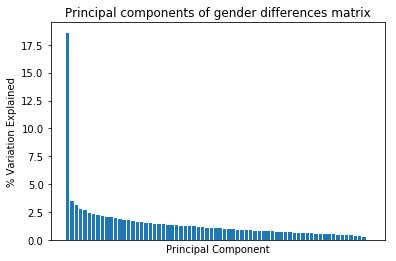

In [11]:
eig_plot_percent('gender', currentmodel, save=False) #saves to your working directory
#eig_plot_percent('moral', currentmodel, save=False)
#eig_plot_percent('health', currentmodel, save=False)
#eig_plot_percent('ses', currentmodel, save=False)

**THIRD, let's look to see if these directions are unique from each other**

Our concern was that all these dimensions might just be capturing valence. 

In [23]:
#extract all four direction vectors, using the Bolukbasi method here:
pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('gender', currentmodel)
genderdirectionVec= PCA_get_directionVec(pos_words, neg_words, currentmodel, train_index_list=None)[0] #for the Larsen method, change this to MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)

pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('moral', currentmodel)
moraldirectionVec= PCA_get_directionVec(pos_words, neg_words, currentmodel, train_index_list=None)[0] #for the Larsen method, change this to MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)

pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('health', currentmodel)
healthdirectionVec= PCA_get_directionVec(pos_words, neg_words, currentmodel, train_index_list=None)[0] #for the Larsen method, change this to MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)

pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('ses', currentmodel)
sesdirectionVec= PCA_get_directionVec(pos_words, neg_words, currentmodel, train_index_list=None)[0] #for the Larsen method, change this to MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)

#look at the cosine simiarlity between each possible pair of direction vectors. Cosine similarity will tell us if these directions are capturing the exact same meaning, in which case the cosine similarity will be -1 or 1. 
print("Cosine Similarity between gender and morality is: " + str(1 - spatial.distance.cosine(genderdirectionVec, moraldirectionVec))) #similarity is 1-distance
print("Cosine Similarity between gender and health is: " + str(1 - spatial.distance.cosine(genderdirectionVec, healthdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between gender and ses is: " + str(1 - spatial.distance.cosine(genderdirectionVec, sesdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between morality and health is: " + str(1 - spatial.distance.cosine(moraldirectionVec, healthdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between morality and ses is: " + str(1 - spatial.distance.cosine(moraldirectionVec, sesdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between health and ses is: " + str(1 - spatial.distance.cosine(healthdirectionVec, sesdirectionVec))) #similarity is 1-distance

Number of pos training words: 70 Number of neg training words: 70
Number of pos training words: 80 Number of neg training words: 80
Number of pos training words: 65 Number of neg training words: 65
Number of pos training words: 50 Number of neg training words: 50
Cosine Similarity between gender and morality is: -0.0497071978411987
Cosine Similarity between gender and health is: -0.08629472826607598
Cosine Similarity between gender and ses is: 0.09877374764320457
Cosine Similarity between morality and health is: 0.7008656161669113
Cosine Similarity between morality and ses is: 0.28147262602716827
Cosine Similarity between health and ses is: 0.24647600753823207


**FOURTH, let's check how similar the directions extracted from both methods are to each other**

In [24]:
#extract all four direction vectors:
pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('gender', currentmodel)
genderdirectionVec_larsen= MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)
genderdirectionVec_boluk= PCA_get_directionVec(pos_words, neg_words, currentmodel, train_index_list=None)[0] 

pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('moral', currentmodel)
moraldirectionVec_larsen= MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)
moraldirectionVec_boluk= PCA_get_directionVec(pos_words, neg_words, currentmodel, train_index_list=None)[0] 

pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('health', currentmodel)
healthdirectionVec_larsen= MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)
healthdirectionVec_boluk= PCA_get_directionVec(pos_words, neg_words, currentmodel, train_index_list=None)[0] 

pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('ses', currentmodel)
sesdirectionVec_larsen= MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)
sesdirectionVec_boluk= PCA_get_directionVec(pos_words, neg_words, currentmodel, train_index_list=None)[0] 

#look at cosine simiarlity between each possible pair of direction vectors. Cosine similarity will tell us if these directions are capturing the exact same meaning, in which case the cosine similarity will be -1 or 1. 
print("Cosine Similarity between larsen and bolukbasi methods for gender direction: " + str(1 - spatial.distance.cosine(genderdirectionVec_larsen, genderdirectionVec_boluk))) #similarity is 1-distance
print("Cosine Similarity between larsen and bolukbasi methods for morality direction: " + str(1 - spatial.distance.cosine(moraldirectionVec_larsen, moraldirectionVec_boluk))) #similarity is 1-distance
print("Cosine Similarity between larsen and bolukbasi methods for health direction: " + str(1 - spatial.distance.cosine(healthdirectionVec_larsen, healthdirectionVec_boluk))) #similarity is 1-distance
print("Cosine Similarity between larsen and bolukbasi methods for ses direction: " + str(1 - spatial.distance.cosine(sesdirectionVec_larsen, sesdirectionVec_boluk))) #similarity is 1-distance


Number of pos training words: 70 Number of neg training words: 70
Number of pos training words: 80 Number of neg training words: 80
Number of pos training words: 65 Number of neg training words: 65
Number of pos training words: 50 Number of neg training words: 50
Cosine Similarity between larsen and bolukbasi methods for gender direction: 0.9740058078933278
Cosine Similarity between larsen and bolukbasi methods for morality direction: -0.9683411186335129
Cosine Similarity between larsen and bolukbasi methods for health direction: -0.9745905649811049
Cosine Similarity between larsen and bolukbasi methods for ses direction: -0.9761921333985204


You'll notice that, for each of the four dimensions, the cosine simiarlities between the version ectracted with the Bolukbasi method and the version extracted with the Larsen method is close to 1 or -1. A cosine simialrity close to 1 suggests the two versions are nearly the same vector and pointing in the same direction. A cosine similarity close close to -1, suggests the two vesrions are nearly the same vector, but pointing in exactly opposite directions. 

<a id='Results'></a> 
# Part 5: Let's extract a dimension (gender, morality, health, or socioeconomic status) and then see how words are classified according to that dimension

For each dimension, we'll look at how the dimension classifies the **training** words used to find the dimension and then a fresh set of **testing** words *not* used to find the dimension.

Finally, we'll look at how the dimension classifies a set of **words about obesity and body weight**. Is obesity connoted with feminininity or masculinity? Morality or immorality? Health or illness? Wealth or poverty?  Here you can stick in your own words too and see how they are classified. 

#### Select the subspace you want to examine below, with our trained model: 

In [52]:
current_subspace = subspaceselector("ses") #choose, gender, moral, health, or ses

Run **do_projections()** to lump together a lot of the functions we've used so far, to classify words!

In brief, this function gives us predictions, words, and expected classes for our training and testing set. It will then print the training and testing accuracy for the subspace you selected in subspaceselector(), above. 

It is *fed*:
* the dimension we're interested in ('gender', 'moral', 'health', or 'ses'), which you specified abvoe with subspaceselector
* optionally, a set of words you want to classify (we'll look at obese lexicon later).
* our trained Word2Vec model we loaded earlier in this notebook, called currentmodel
* extraction method, either 'bolukbasi' or 'larsen'

It *returns*:
* train_word_list = set of training words
* predictions_train = predicted classes for the training words. 1 is feminine/moral/healthy/high SES. 0 is masculine/immoral/unhealthy/low SES.
* projections_train = predictions (scalars) for the training words. Postive values are feminine/moral/healthy/high SES. Negative values are masculine/immoral/unhealthy/low SES.
* train_classes = expected classes for the training set of words. 1 is feminine/moral/healthy/high SES. 0 is masculine/immoral/unhealthy/low SES.
* test_word_list = set of testing words. 
* predictions_test = predicted classes for the testing words. 1 is feminine/moral/healthy/high SES. 0 is masculine/immoral/unhealthy/low SES.
* projections_test = predictions (scalars) for the testing words. Postive values are feminine/moral/healthy/high SES. Negative values are masculine/immoral/unhealthy/low SES.
* test_classes = expected classes for the testing set of words. 1 is feminine/moral/healthy/high SES. 0 is masculine/immoral/unhealthy/low SES.
* predictions_new_word_list = predicted classes for the new words of interest. 1 is feminine/moral/healthy/high SES. 0 is masculine/immoral/unhealthy/low SES.
* projections_new_word_list = predictions (scalars) for the new words of interest. Postive values are feminine/moral/healthy/high SES. Negative values are masculine/immoral/unhealthy/low SES.


In [53]:
train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test,\
    test_classes, predictions_new_word_list, projections_new_word_list \
    = do_projections(current_subspace.subspaceselection, None, currentmodel, method= 'bolukbasi')

Number of pos training words: 50 Number of neg training words: 50
Number of test words in model vocabulary, out of 60: 60
Percent- Training accuracy: 0.93 Testing accuracy: 1.0
Number- Training accuracy: 93 Testing accuracy: 60


####  Visualize Performance of Our Classification Method on Test Words for the Dimension Selected Above (in subspaceselector):

Number of pos training words: 70 Number of neg training words: 70
Number of test words in model vocabulary, out of 60: 60
Percent- Training accuracy: 0.8642857142857143 Testing accuracy: 0.9333333333333333
Number- Training accuracy: 121 Testing accuracy: 56


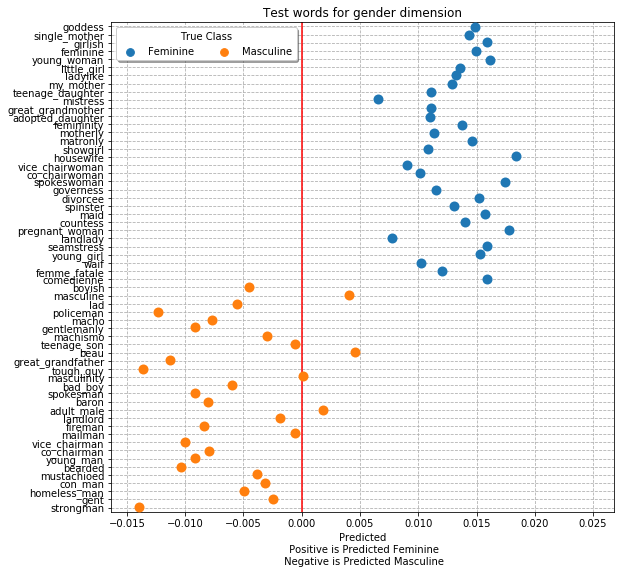

In [39]:
#get words, predictions, and classes for training and testing set
train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test,\
    test_classes, predictions_new_word_list, projections_new_word_list \
    = do_projections(current_subspace.subspaceselection, None, currentmodel, method='bolukbasi')
    
#visualization
rcParams['figure.figsize'] = 9,9
#xlim([-.03, .03])

test_classes_relabeled=[] #quick hack to get legend to show Positive/Negative instead of 0/1
for i in test_classes:
    if i==1:
        test_classes_relabeled.append(current_subspace.pos_coded)
    else:
        test_classes_relabeled.append(current_subspace.neg_coded)

myplot= stripplot(projections_test, test_word_list, test_classes_relabeled, jitter=True, size=10)
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True, title="True Class", fancybox=True)

plt.axvline(x=0, color='r', linestyle='-')
plt.title('Test words for '+ current_subspace.subspaceselection + ' dimension')
plt.xlabel('Predicted' + '\n Positive is Predicted ' + current_subspace.pos_coded + '\n Negative is Predicted ' + current_subspace.neg_coded)
myplot.grid(b=True, linestyle='dashed')
plt.show()

#### Now lets try with words about body weight and health:

Number of pos training words: 50 Number of neg training words: 50
Number of test words in model vocabulary, out of 60: 60
Percent- Training accuracy: 0.93 Testing accuracy: 1.0
Number- Training accuracy: 93 Testing accuracy: 60


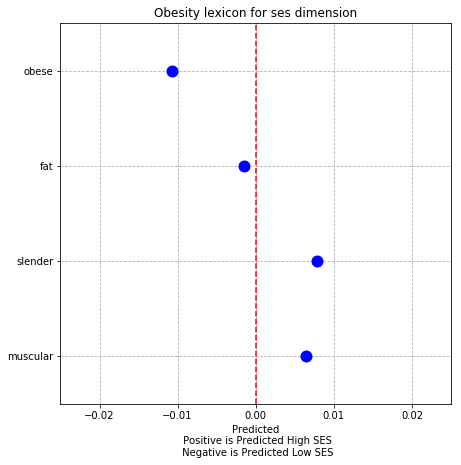

In [54]:
#obese_words_seeifinmodel=['obese', 'obesity', 'diabetic', 'diabetes', 'weight', 'overweight', 'thin', 'slender', 'burly',
                #'muscular', 'diet', 'dieting', 'health', 'healthy', 'unhealthy', 'fat', 'anorexic', 'anorexia', 'bulimia', 
                #'beautiful', 'handsome', 'overeating', 'exercise', 'sedentary', 'bulimic', 'morbidly_obese', 'normal_weight',
                #'seriously_overweight']
obese_words_seeifinmodel=['obese','fat', 'slender', 'muscular']

obese_words= []

#check if these words are in your model
for i in obese_words_seeifinmodel:
    try:
        currentmodel.wv[i]
        obese_words.append(i)
    except:
        print(str(i) + " was not in this model's vocabulary and has been removed")
        continue
    
#get words, predictions, and classes for training and obesity set
train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test,\
    test_classes, predictions_new_word_list, projections_new_word_list \
    = do_projections(current_subspace.subspaceselection, obese_words, currentmodel, method= 'bolukbasi')
    
#visualization
rcParams['figure.figsize'] = 7, 7
#xlim([-.03, .03])
myplot= stripplot(projections_new_word_list, obese_words, color= 'blue', size=12)
plt.axvline(x=0, color='red', linestyle='dashed')
plt.title('Obesity lexicon for '+ current_subspace.subspaceselection + ' dimension')
plt.xlabel('Predicted' + '\n Positive is Predicted ' + current_subspace.pos_coded + '\n Negative is Predicted ' + current_subspace.neg_coded)
plt.xlim((-.025, .025))  
#plt.yticks(fontsize=20)
#plt.xticks(fontsize=12)

#plt.tick_params(axis='y', which='minor', labelsize=20)
myplot.grid(b=True, linestyle='dashed')
plt.show()

#### Write projection for training/testing/obese keywords results to a CSV

In [42]:
train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test,\
    test_classes, predictions_new_word_list, projections_new_word_list \
    = do_projections(current_subspace.subspaceselection, obese_words, currentmodel, method= 'bolukbasi')

with open(r'Results.csv', 'a') as f:
    writer0 = writer(f)
    writer0.writerow([current_subspace.subspaceselection + '_Train']*len(train_word_list))  #change the headings as needed for Gender,Moral, Health, SES
    writer0.writerow(train_word_list)
    writer0.writerow(train_classes) #expected class (0/1)
    writer0.writerow(predictions_train) #predicted class (0/1)
    writer0.writerow(projections_train) #projections (scalar)

    writer0.writerow([current_subspace.subspaceselection + '_Test']*len(test_word_list)) #change the headings as needed for Gender, Moral, Health, SES
    writer0.writerow(test_word_list) #word
    writer0.writerow(test_classes) #expected class (0/1)
    writer0.writerow(predictions_test) #predicted class (0/1)
    writer0.writerow(projections_test) #projections (scalar)
    
    writer0.writerow([current_subspace.subspaceselection + '_Obesity']*len(obese_words)) #change the headings as needed for Gender, Moral, Health, SES, and if another set of words other than the obese_words are used here
    writer0.writerow(obese_words) #word
    writer0.writerow(predictions_new_word_list) #predicted class (0/1)
    writer0.writerow(projections_new_word_list) #projections (scalar)


Number of pos training words: 70 Number of neg training words: 70
Number of test words in model vocabulary, out of 60: 60
Percent- Training accuracy: 0.8642857142857143 Testing accuracy: 0.9333333333333333
Number- Training accuracy: 121 Testing accuracy: 56


Extra - For gender, examine how a few stereotypically gendered words are classified with this method

Number of pos training words: 70 Number of neg training words: 70
Number of test words in model vocabulary, out of 60: 60
Percent- Training accuracy: 0.8642857142857143 Testing accuracy: 0.9333333333333333
Number- Training accuracy: 121 Testing accuracy: 56


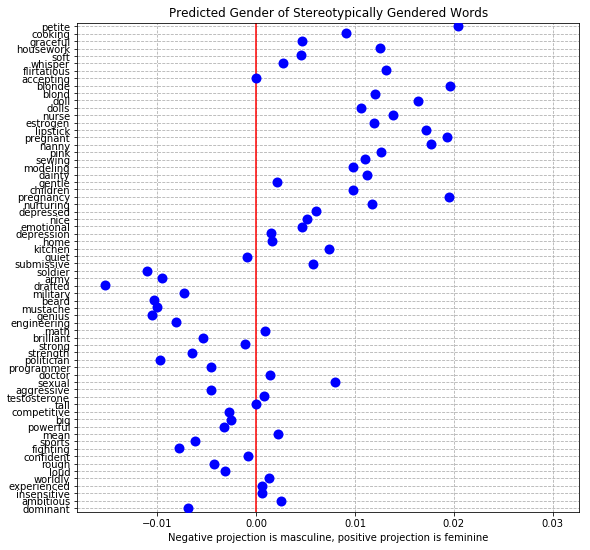

In [38]:
gender_stereotypes_seeifinmodel=['petite', 'cooking', 'graceful',  'housework', 'soft', 'whisper', 'flirtatious', 'accepting', 'blonde', 'blond', 'doll', 'dolls','nurse',  'estrogen', 'lipstick','pregnant', 'nanny', 'pink', 
                 'sewing', 'modeling', 'dainty', 'gentle', 'children','pregnancy', 'nurturing', 'depressed', 'nice', 'emotional','depression', 'home', 'kitchen', 'quiet', 'submissive',
                   'soldier', 'army', 'drafted', 'military',   'beard', 'mustache', 'genius', 'engineering', 'math', 
                  'brilliant', 'strong', 'strength',  'politician', 'programmer','doctor', 'sexual', 'aggressive', 
                    'testosterone', 'tall', 'competitive', 'big', 'powerful', 'mean', 'sports', 'fighting', 'confident', 'rough', 'loud', 'worldly',
                   'experienced', 'insensitive', 'ambitious', 'dominant']
gender_stereotypes= []

#check if these words are in your model
for i in gender_stereotypes_seeifinmodel:
    try:
        currentmodel.wv[i]
        gender_stereotypes.append(i)
    except:
        print(str(i) + " was not in this model's vocabulary and has been removed")
        continue


train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test, test_classes, predictions_new_word_list, projections_new_word_list  = do_projections('gender', gender_stereotypes, currentmodel,  method='bolukbasi')

#Visualization
rcParams['figure.figsize'] = 9,9
#xlim([-.03, .03])
myplot= stripplot(projections_new_word_list, gender_stereotypes, color= 'blue', jitter=True, size=10)
plt.axvline(x=0, color='r', linestyle='-')
plt.title('Predicted Gender of Stereotypically Gendered Words')
plt.xlabel('Negative projection is masculine, positive projection is feminine')
myplot.grid(b=True, linestyle='dashed')
plt.show()